## Описание задачи

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и
планирует будущие продажи. Для оптимизации процессов надо выделить пользователей,
которые готовы совершить покупку в ближайшее время.

Проведем анализ данных о покупках и маркетинговых операциях онлайн магазина

Построим модель и предскажем вероятность покупки в течение 90 дней


In [2]:
import pandas as pd
import mth_2 as m

## Загрузка данных

In [3]:
fldr_1 = 'D:\\Dev\\project_mth_2\\filtered_data\\'
f_names = ['apparel-messages.csv', 'apparel-target_binary.csv', 'apparel-purchases.csv', 'full_campaign_daily_event.csv', 'full_campaign_daily_event_channel.csv']

def rcsv(f_name):
    data = pd.read_csv(fldr_1 + f_name,parse_dates=True)
    print('===='+f_name+'====')
    data.info()
    return data

In [4]:
a_msg = rcsv(f_names[0])
a_targ_b = rcsv(f_names[1])
a_pur = rcsv(f_names[2])
f_cde= rcsv(f_names[3])
f_cde_f = rcsv(f_names[4])

====apparel-messages.csv====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB
====apparel-target_binary.csv====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB
====apparel-purchases.csv====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------      

### Вывод

Данные загружены. Получены следующие дата фреймы:

        a_msg: apparel-messages.csv --история рекламных рассылок, 12739798 записей
        a_targ_b: apparel-target_binary.csv --Таблица с целевым признаком, совершит ли клиент покупку в течении 90 дней. 49849 записей
        a_pur: apparel-purchases -- история покупок, 202208
        f_cde: full_campaign_daily_event.csv -- Агрегация общей базы рассылок по дням и типам событий. 131072 
        f_cde_f: full_campaign_daily_event_channel.csv -- Агрегация по дням с учетом событий и каналов рассылки. 131072 

В полученных данных видна структура:

    a_targ_b -- корневая таблица.
    a_targ_b связана 1:М к a_msg и a_pur
    a_msg связана с f_cde и f_cde_f по bulk_campaign_id

1. Таблицы не содержат пропуски
2. Целевой признак известен только у 49849 клиентов, тогда как в остальных таблицах записей больше
3. Типы данных нужно будет скорректировать
    



## Предобработка данных

    Выполним преобработку данных, рассмотрим:
    
    Дубли
    Аномалии
    Пропуски
    Типы данных
    Подготовка данных


### Типы данных

In [74]:
##Проставим дату, там где дата
a_msg['date'] = a_msg['date'].astype('datetime64[ns]')
a_msg['created_at'] = a_msg['created_at'].astype('datetime64[ns]')
a_pur['date'] = a_pur['date'].astype('datetime64[ns]')

f_cde['date'] = f_cde['date'].astype('datetime64[ns]')
f_cde_f['date'] = f_cde_f['date'].astype('datetime64[ns]')


### Дубли

In [15]:
##Уберем явные дубли:
print('a_msg: ')
m.drop_dup(a_msg)
print('a_pur: ')
m.drop_dup(a_pur)
print('a_targ_b: ')
m.drop_dup(a_targ_b)
print('f_cde: ')
m.drop_dup(f_cde)
print('f_cde_f: ')
m.drop_dup(f_cde_f)

a_msg: 
Кол-во дублей ДО удаления:  48610
Кол-во ДО удаления:  12739798
Кол-во ПОСЛЕ удаления:  12691188

a_pur: 
Кол-во дублей ДО удаления:  73020
Кол-во ДО удаления:  202208
Кол-во ПОСЛЕ удаления:  129188

a_targ_b: 
Кол-во дублей ДО удаления:  0
Кол-во ДО удаления:  49849
Кол-во ПОСЛЕ удаления:  49849

f_cde: 
Кол-во дублей ДО удаления:  0
Кол-во ДО удаления:  131072
Кол-во ПОСЛЕ удаления:  131072

f_cde_f: 
Кол-во дублей ДО удаления:  0
Кол-во ДО удаления:  131072
Кол-во ПОСЛЕ удаления:  131072



In [16]:
##Неявные дубли
a_targ_b['client_id'].duplicated().sum()
#a_targ_b

display(a_pur)

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843
...,...,...,...,...,...,...
202203,1515915626010261344,1,1499.0,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.0,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.0,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490


### Аномалии

In [17]:
#a_msg: apparel-messages.csv --история рекламных рассылок, 12739798 записей
#a_targ_b: apparel-target_binary.csv --Таблица с целевым признаком, совершит ли клиент покупку в течении 90 дней. 49849 записей
#a_pur: apparel-purchases -- история покупок, 202208
#f_cde: full_campaign_daily_event.csv -- Агрегация общей базы рассылок по дням и типам событий. 131072 
#f_cde_f: full_campaign_daily_event_channel.csv -- Агрегация по дням с учетом событий и каналов рассылки. 131072 

In [ ]:
##a_targ_b
display(a_targ_b.head(5))
a_targ_b['client_len'] = a_targ_b['client_id'].astype(str).str.len()
print(a_targ_b['client_len'].value_counts()) ## длина client_id всегда 19 и тип int
print(a_targ_b['target'].value_counts()) ## target = 1 сильно меньше чем 0(1 из 50 клиентов что-то купит в течении 90 дней). Значения 0 и 1
a_targ_b = a_targ_b.drop('client_len',axis=1)
# a_targ_b аномалий нет

,client_id,target,client_len
0,1515915625468060902,0,19
1,1515915625468061003,1,19
2,1515915625468061099,0,19
3,1515915625468061100,0,19
4,1515915625468061170,0,19


client_len
19    49849
Name: count, dtype: int64
target
0    48888
1      961
Name: count, dtype: int64


In [ ]:
#a_msg
a_msg.info()
display(a_msg.head(5))

print('date min max: ',a_msg['date'].min(), a_msg['date'].max())
print('created_at min max: ',a_msg['created_at'].min(), a_msg['created_at'].max())

display(a_msg['channel'].value_counts()) ## аномалий нет
display(a_msg['event'].value_counts()) ## аномалий нет, какие то события встречаются очень редко, какие-то носят регулярный характер
display(a_msg['bulk_campaign_id'].value_counts()) ##всего 2709 кампаний, некоторые кампании содержат 1 сообщение т.е. индивидуальные рассылки видимо...
#print(a_msg['message_id'].astype(str).str.len().value_counts()) ## у 127 сообщений длина 37, но сами записи выглядят нормально

#a_msg['message_id_len'] = a_msg['message_id'].astype(str).str.len()
#a_msg.query('message_id_len == 37')

#аномалий нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


date min max:  2022-05-19 00:00:00 2024-02-15 00:00:00
created_at min max:  2022-05-19 00:14:20 2024-02-15 23:58:40


channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

bulk_campaign_id
14272    104479
14276     63826
4679      50621
11760     45985
14081     44884
          ...  
634           1
1080          1
4899          1
657           1
721           1
Name: count, Length: 2709, dtype: int64

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at,message_id_len
52635,998,1515915625508857763,1515915625508857763-998-61260dbd39ae5,open,email,2022-05-21,2022-05-21 04:26:36,37
54287,998,1515915625504793190,1515915625504793190-998-61260dba460f0,open,email,2022-05-21,2022-05-21 17:34:16,37
54288,998,1515915625504793190,1515915625504793190-998-61260dba460f0,click,email,2022-05-21,2022-05-21 17:34:26,37
60344,585,1515915625556152577,1515915625556152577-585-60e84159c0912,open,email,2022-05-22,2022-05-22 13:02:04,37
83400,998,1515915625508857763,1515915625508857763-998-61260dbd39ae5,open,email,2022-05-24,2022-05-24 19:29:46,37
...,...,...,...,...,...,...,...,...
7610798,563,1515915625471518311,1515915625471518311-563-60e55f1a5a7e6,click,email,2023-09-09,2023-09-09 21:36:38,37
7614320,563,1515915625471518311,1515915625471518311-563-60e55f1a5a7e6,click,email,2023-09-10,2023-09-10 07:46:59,37
7955426,676,1515915625579547560,1515915625579547560-676-60f9267f11f13,click,email,2023-09-22,2023-09-22 14:44:06,37
8150912,908,1515915625470883759,1515915625470883759-908-611b61faabc1d,click,email,2023-10-02,2023-10-02 13:56:00,37


In [69]:
a_pur.loc[a_pur['category_ids']=='[]','category_ids'] = '[0]'

In [ ]:
#a_pur: apparel-purchases -- история покупок, 202208

display(a_pur.head(5))
print('date min max: ',a_pur['date'].min(), a_pur['date'].max()) ## похоже как и с маркетинговыми сообщениями, история ведется с мая 2022 года, аномалий не вижу
display(a_pur['quantity'].value_counts()) ## большая часть чеков с 1 покупкой. Аномалий не вижу

display(a_pur['category_ids'].value_counts()) ## часть покупок имеют категорию [] и [None] , по сути пропуск или можно сказать что товары без категорий
a_pur.loc[a_pur['category_ids']=='[]','category_ids'] = '[0]'
a_pur.loc[a_pur['category_ids']=='[None]','category_ids'] = '[0]'
## Представим их как товары 0 категории

print('рассмотрим price:')
display(a_pur['price'].describe())

display(a_pur.query('price < 10')['category_ids'].value_counts()) ## часть покупок меньше 10 рублей
##Примем то, что такие покупки не существенны, уберем их из набора
a_pur = a_pur.query('price > 10')

##a_pur готов 

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


date min max:  2022-05-16 00:00:00 2024-02-16 00:00:00


quantity
1     201323
2        751
3         94
4         12
6          5
10         4
15         3
20         3
5          3
25         2
9          2
30         2
13         1
18         1
8          1
7          1
Name: count, dtype: int64

category_ids
['4', '28', '57', '431']            8626
['4', '28', '260', '420']           6989
[0]                                 6843
['4', '28', '244', '432']           6821
['4', '28', '275', '421']           4936
                                    ... 
['5562', '5597', '5696', '5529']       1
['4', '29', '314', '1579']             1
['5562', '5597', '5696', '751']        1
['5562', '5558', '5617', '1102']       1
['4', '28', '44', '528']               1
Name: count, Length: 932, dtype: int64

рассмотрим price:


count    202208.000000
mean       1193.301516
std        1342.252664
min           1.000000
25%         352.000000
50%         987.000000
75%        1699.000000
max       85499.000000
Name: price, dtype: float64

category_ids
[0]                                 5903
['5562', '5597', '5691', '889']      327
['4', '1822', '1821', '1613']        100
['4', '27', '205', '650']             78
['5562', '5536', '5707', '1173']      39
                                    ... 
['5562', '5633', '5646', '765']        1
['5562', '5633', '5569', '581']        1
['5562', '5597', '5566', '913']        1
['5562', '5597', '5565', '1214']       1
['5562', '5589', '5624', '1690']       1
Name: count, Length: 351, dtype: int64

In [ ]:
#f_cde: full_campaign_daily_event.csv -- Агрегация общей базы рассылок по дням и типам событий. 131072 
#print(f_cde.info())
print('date min max:',f_cde['date'].min(),f_cde['date'].max())
display(f_cde.bulk_campaign_id.value_counts())

f_cde.head(5)
##Аномалий нет

date min max: 2022-05-19 00:00:00 2024-05-15 00:00:00


bulk_campaign_id
2499     464
3557     447
5286     427
3401     416
4679     404
        ... 
15146      1
15147      1
13341      1
15149      1
15150      1
Name: count, Length: 3181, dtype: int64

,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,...,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
0,2022-05-19,563,0,0,0,4,0,0,0,0,...,4,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,0,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
#f_cde_f: full_campaign_daily_event_channel.csv -- Агрегация по дням с учетом событий и каналов рассылки. 131072 
display(f_cde_f.head(5))
display(f_cde.bulk_campaign_id.value_counts()) ## количество кампаний такое же как и в f_cde

##Аномалий не вижу

,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,...,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
0,2022-05-19,563,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022-05-19,577,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022-05-19,622,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022-05-19,634,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2022-05-19,676,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


bulk_campaign_id
2499     464
3557     447
5286     427
3401     416
4679     404
        ... 
15146      1
15147      1
13341      1
15149      1
15150      1
Name: count, Length: 3181, dtype: int64

### Вывод

Предобработка завершена.

    Типы приведены к норме.
    Дубли выявлены и устранены.
    Аномалии выявлены и устранены

В полученных данных видна структура:

    a_targ_b -- корневая таблица.
    a_targ_b связана 1:М к a_msg и a_pur

    a_msg связана с f_cde и f_cde_f по bulk_campaign_id

## Подготовка новой таблицы

Для задачи обучения модели, одной таблицы a_targ_b не достаточно.

Необходимо создать новую таблицу, объединив признаки таблиц a_targ_b, a_msg и a_pur

### Таблица маркетинговых активностей клиента

In [104]:
##Отберем не все типы активностей, а встречающиеся хотябы 10тыс раз
s = a_msg['event'].value_counts()
act_events = list(s[s>10000].index)
#list(filter(lambda x: x>10000, a_msg['event'].value_counts()))
print(act_events)

['send', 'open', 'click', 'purchase', 'hard_bounce', 'soft_bounce']


In [108]:
a_msg['date'] = a_msg['date'].astype('datetime64[ns]')

for channel in list(a_msg['channel'].value_counts().index):
    a_msg[channel] = (a_msg['channel']==channel).astype(int)

for event in act_events:
    a_msg[event] = (a_msg['event']==event).astype(int)

val_col = [
 'message_id',
 'mobile_push',
 'email',
 'date',
 'send',
 'open',
 'click',
 'purchase',
 'hard_bounce',
 'soft_bounce']

a_msg_p = a_msg.pivot_table(
    index='client_id',
    values = val_col, aggfunc={
        'message_id':'count', 
        'mobile_push':'sum',
        'email':'sum',
        'date':'max',
        'send':'sum',
        'open':'sum',
        'click':'sum',
        'purchase':'sum',
        'hard_bounce':'sum',
        'soft_bounce':'sum'})
a_msg_p = a_msg_p.rename(columns={'message_id':'message_count','date':'last_date'})
#a_msg_p = a_msg_p.reset_index(drop=False)
#a_msg_p = a_msg_p.set_index('client_id')    

a_msg_p.head(5) ##Таблица маркетинговых активностей по каждому клиенту
a_msg_p.info()
#print(list(filter(lambda x: x==True, a_msg_p.index.duplicated()))) ##проверим что нет дублей по client_id

<class 'pandas.core.frame.DataFrame'>
Index: 53329 entries, 1515915625468060902 to 1515915626010288690
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   click          53329 non-null  int64         
 1   last_date      53329 non-null  datetime64[ns]
 2   email          53329 non-null  int64         
 3   hard_bounce    53329 non-null  int64         
 4   message_count  53329 non-null  int64         
 5   mobile_push    53329 non-null  int64         
 6   open           53329 non-null  int64         
 7   purchase       53329 non-null  int64         
 8   send           53329 non-null  int64         
 9   soft_bounce    53329 non-null  int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 4.5 MB


### Подготовим таблицу статистики по покупкам клиента

In [99]:
a_pur.info()
a_pur['date'] = a_pur['date'].astype('datetime64[ns]')
print(a_pur['date'].max())
print(a_pur['date'].min())

<class 'pandas.core.frame.DataFrame'>
Index: 193656 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     193656 non-null  int64         
 1   quantity      193656 non-null  int64         
 2   price         193656 non-null  float64       
 3   category_ids  193656 non-null  object        
 4   date          193656 non-null  datetime64[ns]
 5   message_id    193656 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 10.3+ MB
2024-02-16 00:00:00
2022-05-16 00:00:00


In [110]:
a_pur['date_year'] = a_pur['date'].dt.year
a_pur['date_qrt'] = a_pur['date'].dt.quarter
a_pur_pvt = a_pur.pivot_table(index=['client_id','date_year','date_qrt'], values = ['message_id','price','date'], aggfunc={'message_id':'count' ,'price':'sum','date':'max'})
a_pur_pvt = a_pur_pvt.reset_index()
a_pur_pvt = a_pur_pvt.rename(columns={'message_id':'purch_count', 'price':'sum_price', 'date':'last_purch_date'})

for n in ['2022','2023','2024']:
    a_pur_pvt[n+'_sum'] = a_pur_pvt[a_pur_pvt['date_year']==int(n)]['sum_price']
    a_pur_pvt[n+'_sum'] = a_pur_pvt[n+'_sum'].fillna(0)

    a_pur_pvt[n+'_cnt'] = a_pur_pvt[a_pur_pvt['date_year']==int(n)]['purch_count']
    a_pur_pvt[n+'_cnt'] = a_pur_pvt[n+'_cnt'].fillna(0)

a_pur_pvt = a_pur_pvt.pivot_table(index = 'client_id', 
                                  values = ['last_purch_date','purch_count','sum_price','2022_sum','2022_cnt','2023_sum','2023_cnt','2024_sum','2024_cnt'],
                                  aggfunc={'last_purch_date':'max','purch_count':'sum', 'sum_price':'sum',
                                           '2022_sum':'sum','2022_cnt':'sum','2023_sum':'sum','2023_cnt':'sum','2024_sum':'sum','2024_cnt':'sum'})
#давность последней покупки
#частота покупок
#общая сумма трат
#Динамика покупок

display(a_pur_pvt.head(5)) ## статистика по покупкам
a_pur_pvt.info()

,2022_cnt,2022_sum,2023_cnt,2023_sum,2024_cnt,2024_sum,last_purch_date,purch_count,sum_price
client_id,,,,,,,,,
1515915625468060902,7.0,6993.0,0.0,0.0,0.0,0.0,2022-05-27,7,6993.0
1515915625468061003,0.0,0.0,7.0,16235.0,0.0,0.0,2023-01-04,7,16235.0
1515915625468061099,1.0,299.0,0.0,0.0,0.0,0.0,2022-05-17,1,299.0
1515915625468061100,0.0,0.0,0.0,0.0,2.0,2098.0,2024-02-10,2,2098.0
1515915625468061170,0.0,0.0,17.0,33587.0,0.0,0.0,2023-06-17,17,33587.0


<class 'pandas.core.frame.DataFrame'>
Index: 49792 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   2022_cnt         49792 non-null  float64       
 1   2022_sum         49792 non-null  float64       
 2   2023_cnt         49792 non-null  float64       
 3   2023_sum         49792 non-null  float64       
 4   2024_cnt         49792 non-null  float64       
 5   2024_sum         49792 non-null  float64       
 6   last_purch_date  49792 non-null  datetime64[ns]
 7   purch_count      49792 non-null  int64         
 8   sum_price        49792 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 3.8 MB


### Таблица популярных категорий клиента

In [121]:
a_pur['category_ids'].value_counts()
a_pur_cat_n = a_pur.copy()
a_pur_cat_n['cat_cnt'] = 0
a_pur_cat_n = a_pur_cat_n.pivot_table(index = ['client_id','category_ids'],  values='cat_cnt', aggfunc='count')
a_pur_cat_n = a_pur_cat_n.reset_index()
a_pur_cat_n['cat_max_cnt'] = 0

a_pur_cat_n['cat_max_cnt'] = a_pur_cat_n.groupby('client_id')['cat_cnt'].transform('max')
a_pur_cat_n = a_pur_cat_n.query('cat_cnt == cat_max_cnt')
#a_pur_cat_n = a_pur_cat_n.pivot_table(index = ['client_id','cat_f'],  values='cat_f', columns='cat_max_cnt', aggfunc='max')

a_pur_cat_n = a_pur_cat_n.drop_duplicates(subset=['client_id','cat_cnt'])
a_pur_cat_n = a_pur_cat_n.drop('cat_max_cnt', axis=1)
a_pur_cat_n = a_pur_cat_n.set_index('client_id')
a_pur_cat_n.info() ## Таблица наиболее популярных категорий у клиентов
#a_pur_cat_n[['client_id','cat_cnt']].drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
Index: 49792 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   category_ids  49792 non-null  object
 1   cat_cnt       49792 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


### Построим общую таблицу

In [116]:
#a_targ_b = a_targ_b.set_index('client_id')
a_targ_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  49849 non-null  int64
dtypes: int64(1)
memory usage: 778.9 KB


In [120]:
#a_pur_pvt ## статистика по покупкам
#a_msg_p ##Таблица маркетинговых активностей по каждому клиенту 49849 
#a_targ_b ## таблица с целевым признаком
#a_pur_cat_n ## Таблица наиболее популярных категорий у клиентов 49849 

## соединим таблицы
fin_data = a_targ_b.join(a_pur_pvt).join(a_msg_p).join(a_pur_cat_n)

## заполним пропуски
fin_data['last_date'] = fin_data['last_date'].fillna(fin_data['last_date'].mean()) 
fin_data = fin_data.fillna(0)

fin_data.info() ## 

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   target           49849 non-null  int64         
 1   2022_cnt         49849 non-null  float64       
 2   2022_sum         49849 non-null  float64       
 3   2023_cnt         49849 non-null  float64       
 4   2023_sum         49849 non-null  float64       
 5   2024_cnt         49849 non-null  float64       
 6   2024_sum         49849 non-null  float64       
 7   last_purch_date  49849 non-null  object        
 8   purch_count      49849 non-null  float64       
 9   sum_price        49849 non-null  float64       
 10  click            49849 non-null  float64       
 11  last_date        49849 non-null  datetime64[ns]
 12  email            49849 non-null  float64       
 13  hard_bounce      49849 non-null  float64       
 14  message_cou

In [122]:
fin_data.head(5)

,target,2022_cnt,2022_sum,2023_cnt,2023_sum,2024_cnt,2024_sum,last_purch_date,purch_count,sum_price,...,email,hard_bounce,message_count,mobile_push,open,purchase,send,soft_bounce,category_ids,cat_cnt
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0,7.0,6993.0,0.0,0.0,0.0,0.0,2022-05-27 00:00:00,7.0,6993.0,...,177.0,0.0,177.0,0.0,35.0,5.0,126.0,0.0,"['4', '27', '176', '458']",2.0
1515915625468061003,1,0.0,0.0,7.0,16235.0,0.0,0.0,2023-01-04 00:00:00,7.0,16235.0,...,166.0,0.0,166.0,0.0,5.0,1.0,154.0,0.0,"['4', '28', '249', '615']",7.0
1515915625468061099,0,1.0,299.0,0.0,0.0,0.0,0.0,2022-05-17 00:00:00,1.0,299.0,...,182.0,2.0,276.0,94.0,51.0,0.0,215.0,0.0,"['4', '28', '290', '424']",1.0
1515915625468061100,0,0.0,0.0,0.0,0.0,2.0,2098.0,2024-02-10 00:00:00,2.0,2098.0,...,0.0,1.0,434.0,434.0,163.0,1.0,267.0,1.0,"['4', '27', '1828', '5717']",2.0
1515915625468061170,0,0.0,0.0,17.0,33587.0,0.0,0.0,2023-06-17 00:00:00,17.0,33587.0,...,202.0,0.0,293.0,91.0,31.0,3.0,243.0,0.0,"['4', '28', '260', '420']",12.0


### Вывод

Таблица fin_data построена записей 49849, как и в целевой таблице a_targ_b

Кроме этого, созданы таблицы:

    #a_pur_pvt ## статистика по покупкам (количество и сумма за год)
    #a_msg_p ##Таблица маркетинговых активностей по каждому клиенту 49849 
    #a_pur_cat_n ## Таблица наиболее популярных категорий у клиентов 49849 



## Анализ данных

In [124]:
#a_msg: apparel-messages.csv --история рекламных рассылок, 12739798 записей
#a_targ_b: apparel-target_binary.csv --Таблица с целевым признаком, совершит ли клиент покупку в течении 90 дней. 49849 записей
#a_pur: apparel-purchases -- история покупок, 202208
#f_cde: full_campaign_daily_event.csv -- Агрегация общей базы рассылок по дням и типам событий. 131072 
#f_cde_f: full_campaign_daily_event_channel.csv -- Агрегация по дням с учетом событий и каналов рассылки. 131072 

#fin_data: общая таблица

In [95]:
a_msg['event'].value_counts()

event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64

Подготовим таблицу статистики по покупкам клиента

Добавим популярную категорию

Составим таблицу для построения модели

In [102]:
#a_targ_b[a_targ_b['client_id'].duplicated()] ## проверка на дубли. уже была
a_targ_b = a_targ_b.set_index('client_id')
display(a_targ_b)

,target
client_id,
1515915625468060902,0
1515915625468061003,1
1515915625468061099,0
1515915625468061100,0
1515915625468061170,0
...,...
1515915626010261344,0
1515915626010266132,0
1515915626010439406,0


In [103]:
#a_pur_pvt ## статистика по покупкам
#a_msg_p ##Таблица маркетинговых активностей по каждому клиенту
#a_targ_b ## таблица с целевым признаком
#a_pur_cat_n ## Таблица наиболее популярных категорий у клиентов

## соединим таблицы
fin_data = a_targ_b.join(a_pur_pvt).join(a_msg_p).join(a_pur_cat_n)

## заполним пропуски
fin_data['last_date'] = fin_data['last_date'].fillna(fin_data['last_date'].mean()) 
fin_data = fin_data.fillna(0)

fin_data.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 49849 entries, 1515915625468060902 to 1515915626010443624
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   target           49849 non-null  int64         
 1   2022_cnt         49849 non-null  float64       
 2   2022_sum         49849 non-null  float64       
 3   2023_cnt         49849 non-null  float64       
 4   2023_sum         49849 non-null  float64       
 5   2024_cnt         49849 non-null  float64       
 6   2024_sum         49849 non-null  float64       
 7   last_purch_date  49849 non-null  object        
 8   purch_count      49849 non-null  float64       
 9   sum_price        49849 non-null  float64       
 10  click            49849 non-null  float64       
 11  last_date        49849 non-null  datetime64[ns]
 12  email            49849 non-null  float64       
 13  hard_bounce      49849 non-null  float64       
 14  message_cou

#### Вывод. 

    Предобработка завершена. Финальная таблица для построения модели - fin_data

## Анализ данных

In [20]:
print(fin_data.columns)
fin_data.describe()

Index(['target', '2022_cnt', '2022_sum', '2023_cnt', '2023_sum', '2024_cnt',
       '2024_sum', 'last_purch_date', 'purch_count', 'sum_price', 'click',
       'last_date', 'email', 'hard_bounce', 'message_count', 'mobile_push',
       'open', 'purchase', 'send', 'soft_bounce', 'category_ids', 'cat_cnt'],
      dtype='object')


,target,2022_cnt,2022_sum,2023_cnt,2023_sum,2024_cnt,2024_sum,last_purch_date,purch_count,sum_price,...,last_date,email,hard_bounce,message_count,mobile_push,open,purchase,send,soft_bounce,cat_cnt
count,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849,49849.000000,49849.000000,...,49849,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,0.019278,1.637365,2131.301611,2.200245,2442.978555,0.218801,266.240466,2023-02-19 01:38:30.329193984,4.056410,4840.520632,...,2024-01-07 10:59:00.831784960,96.919397,0.330518,219.681859,122.762463,50.339365,1.155249,158.458886,0.178860,2.432807
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-05-16 00:00:00,1.000000,1.000000,...,2022-05-19 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-08-23 00:00:00,1.000000,1499.000000,...,2024-01-07 10:59:00.831784960,0.000000,0.000000,81.000000,0.000000,0.000000,1.000000,59.000000,0.000000,1.000000
50%,0.000000,1.000000,296.000000,0.000000,0.000000,0.000000,0.000000,2023-03-05 00:00:00,2.000000,2929.000000,...,2024-02-14 00:00:00,84.000000,0.000000,200.000000,72.000000,15.000000,1.000000,151.000000,0.000000,2.000000
75%,0.000000,2.000000,2499.000000,2.000000,2999.000000,0.000000,0.000000,2023-06-28 00:00:00,5.000000,5677.000000,...,2024-02-15 00:00:00,173.000000,0.000000,322.000000,220.000000,77.000000,1.000000,243.000000,0.000000,3.000000
max,1.000000,218.000000,158042.000000,210.000000,540408.000000,92.000000,387583.000000,2024-02-16 00:00:00,346.000000,540408.000000,...,2024-02-15 00:00:00,878.000000,49.000000,3100.000000,2295.000000,1268.000000,103.000000,2473.000000,133.000000,96.000000
std,0.137503,3.568347,4549.057183,4.412015,5776.044380,1.427124,2611.619778,NaN,5.521669,7312.865458,...,NaN,94.941541,0.903909,175.003220,144.733594,72.126475,1.410531,118.018655,2.702151,2.318449


In [21]:
fin_data['target'].value_counts()

target
0    48888
1      961
Name: count, dtype: int64

Очень большая разница между классами. Попробуем применить оверсемплинг

In [22]:
#fin_data = fin_data.copy()
# вычисляем размер дисбаланса: узнаём, насколько данных мажорного класса больше
delta = fin_data.target.value_counts()[0] - fin_data.target.value_counts()[1]
# отбираем и копируем объекты минорного класса
# их количество будет равно разнице между числом объектов двух классов

sampled_ha = fin_data.query("target==1").sample(delta, replace=True)
# объединяем исходные данные с новыми

fin_data_sampled = pd.concat([fin_data, sampled_ha])
# перемешиваем данные

fin_data_sampled = fin_data_sampled.sample(frac=1)

fin_data_sampled

,target,2022_cnt,2022_sum,2023_cnt,2023_sum,2024_cnt,2024_sum,last_purch_date,purch_count,sum_price,...,email,hard_bounce,message_count,mobile_push,open,purchase,send,soft_bounce,category_ids,cat_cnt
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625500270478,1,1.0,999.0,0.0,0.0,0.0,0.0,2022-08-03,1,999.0,...,77.0,0.0,239.0,162.0,96.0,1.0,132.0,0.0,"['4', '28', '57', '431']",1
1515915625468063026,1,2.0,4698.0,8.0,8766.0,0.0,0.0,2023-12-20,10,13464.0,...,253.0,0.0,253.0,0.0,47.0,2.0,178.0,0.0,"['4', '28', '275', '673']",4
1515915625494942729,0,3.0,6397.0,0.0,0.0,0.0,0.0,2022-06-13,3,6397.0,...,43.0,0.0,43.0,0.0,11.0,1.0,21.0,0.0,"['5562', '5631', '5593', '675']",2
1515915625986893731,0,0.0,0.0,3.0,7497.0,0.0,0.0,2023-11-17,3,7497.0,...,0.0,0.0,83.0,83.0,0.0,1.0,79.0,0.0,"['2', '18', '274', '446']",3
1515915625663543273,1,2.0,243.0,0.0,0.0,0.0,0.0,2022-12-21,2,243.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"['4', '29', '312', '934']",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515915625500269509,0,0.0,0.0,0.0,0.0,4.0,4148.0,2024-01-27,4,4148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"['4', '28', '124', '415']",4
1515915625566817339,0,4.0,7596.0,0.0,0.0,0.0,0.0,2022-08-05,4,7596.0,...,159.0,0.0,159.0,0.0,9.0,3.0,138.0,0.0,"['4', '28', '260', '420']",2
1515915625536048311,0,4.0,10796.0,0.0,0.0,0.0,0.0,2022-07-07,4,10796.0,...,141.0,3.0,262.0,121.0,2.0,2.0,251.0,1.0,"['4', '28', '244', '432']",2


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

#анализ данных
import numpy as np
import math
import re

def plt_corr_mtrx(dt):
    num_col = dt.select_dtypes(exclude=['object']).columns ##Только числовые поля
    plt.figure(figsize=(10, 10))
    sns.heatmap(dt[num_col].corr(), annot=True, cmap='cividis');
    plt.show()

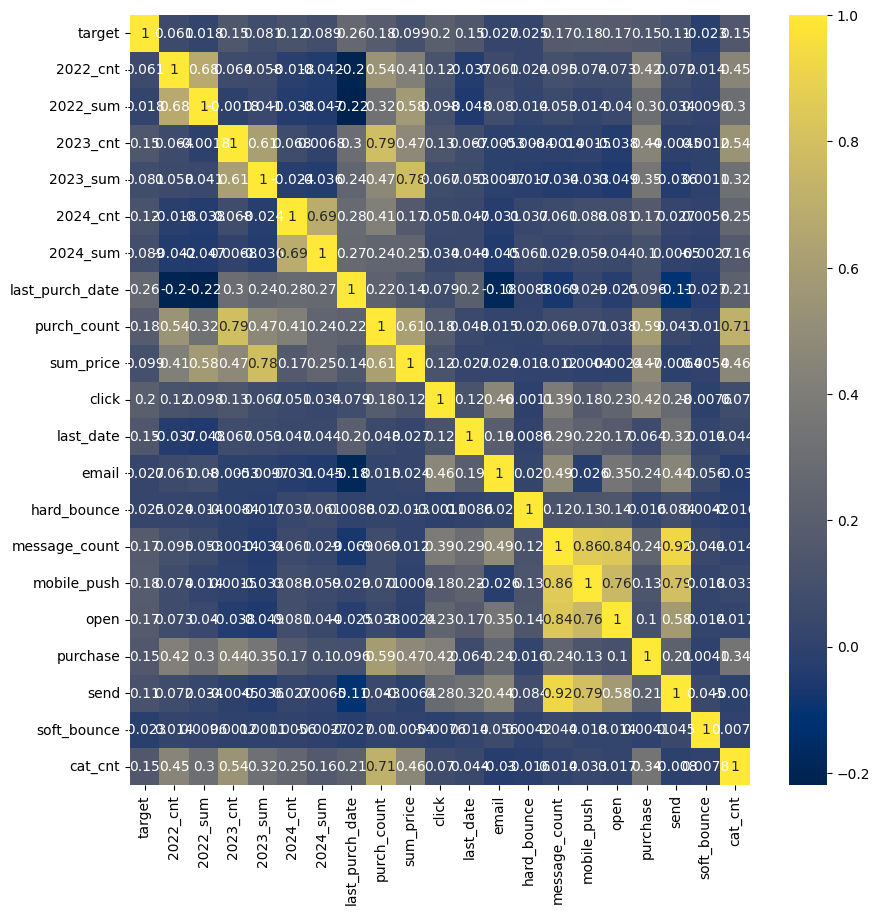

In [24]:
plt_corr_mtrx(fin_data_sampled)

In [25]:
fin_data_sampled

,target,2022_cnt,2022_sum,2023_cnt,2023_sum,2024_cnt,2024_sum,last_purch_date,purch_count,sum_price,...,email,hard_bounce,message_count,mobile_push,open,purchase,send,soft_bounce,category_ids,cat_cnt
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625500270478,1,1.0,999.0,0.0,0.0,0.0,0.0,2022-08-03,1,999.0,...,77.0,0.0,239.0,162.0,96.0,1.0,132.0,0.0,"['4', '28', '57', '431']",1
1515915625468063026,1,2.0,4698.0,8.0,8766.0,0.0,0.0,2023-12-20,10,13464.0,...,253.0,0.0,253.0,0.0,47.0,2.0,178.0,0.0,"['4', '28', '275', '673']",4
1515915625494942729,0,3.0,6397.0,0.0,0.0,0.0,0.0,2022-06-13,3,6397.0,...,43.0,0.0,43.0,0.0,11.0,1.0,21.0,0.0,"['5562', '5631', '5593', '675']",2
1515915625986893731,0,0.0,0.0,3.0,7497.0,0.0,0.0,2023-11-17,3,7497.0,...,0.0,0.0,83.0,83.0,0.0,1.0,79.0,0.0,"['2', '18', '274', '446']",3
1515915625663543273,1,2.0,243.0,0.0,0.0,0.0,0.0,2022-12-21,2,243.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"['4', '29', '312', '934']",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515915625500269509,0,0.0,0.0,0.0,0.0,4.0,4148.0,2024-01-27,4,4148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"['4', '28', '124', '415']",4
1515915625566817339,0,4.0,7596.0,0.0,0.0,0.0,0.0,2022-08-05,4,7596.0,...,159.0,0.0,159.0,0.0,9.0,3.0,138.0,0.0,"['4', '28', '260', '420']",2
1515915625536048311,0,4.0,10796.0,0.0,0.0,0.0,0.0,2022-07-07,4,10796.0,...,141.0,3.0,262.0,121.0,2.0,2.0,251.0,1.0,"['4', '28', '244', '432']",2


## Обучение моделей

Зафиксируем основные параметры

In [26]:
#!pip install lightgbm

from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from statistics import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score

RANDOM_STATE = 42
TEST_SIZE = 0.25

trg = 'target' ## цена - целевой признак

##Определим признаки для шифрования и масштабирования
ohe_columns = ['category_ids'] #
oe_columns = ['category_ids'] #

num_columns = list(fin_data_sampled.columns)
for r in ['target','category_ids', 'last_purch_date','sum_price','last_date']:
    num_columns.remove(r)


X = fin_data_sampled.drop(trg, axis=1)
X = X[num_columns] ##ohe_columns+
y = fin_data_sampled[trg]

##Разделим выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE, test_size=TEST_SIZE
)


ohe_pipe = Pipeline(
    [
        (
            'ohe', OneHotEncoder(drop='first', handle_unknown='error') #handle_unknown='ignore' , sparse=False
        )
    ]
) 

oe_pipe = Pipeline(
    [
        (
            'ohe', OrdinalEncoder() #handle_unknown='ignore' , sparse=False
        )
    ]
) 

num_pipe = Pipeline(
    [        
        (
            'scaler',  StandardScaler() #handle_unknown='ignore'
        )
        
    ]
) 

In [27]:
num_columns

#'last_purch_date','sum_price','last_date',

['2022_cnt',
 '2022_sum',
 '2023_cnt',
 '2023_sum',
 '2024_cnt',
 '2024_sum',
 'purch_count',
 'click',
 'email',
 'hard_bounce',
 'message_count',
 'mobile_push',
 'open',
 'purchase',
 'send',
 'soft_bounce',
 'cat_cnt']

In [28]:
from lightgbm import LGBMClassifier

lgb_preprocessor = ColumnTransformer(
    [
        #'oe', oe_pipe, ohe_columns),
        ('num', num_pipe,  num_columns)
    ], 
    remainder='passthrough'
)
model_lgb = LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    num_leaves=10,
    random_state=RANDOM_STATE
)

In [29]:
df = pd.DataFrame(X_train)
df

,2022_cnt,2022_sum,2023_cnt,2023_sum,2024_cnt,2024_sum,purch_count,click,email,hard_bounce,message_count,mobile_push,open,purchase,send,soft_bounce,cat_cnt
client_id,,,,,,,,,,,,,,,,,
1515915625865892804,0.0,0.0,3.0,6397.0,0.0,0.0,3,5.0,132.0,0.0,132.0,0.0,10.0,1.0,116.0,0.0,2
1515915625490665239,1.0,1699.0,0.0,0.0,0.0,0.0,1,0.0,95.0,0.0,95.0,0.0,0.0,0.0,95.0,0.0,1
1515915625624552599,6.0,4894.0,0.0,0.0,0.0,0.0,6,3.0,24.0,0.0,24.0,0.0,3.0,2.0,16.0,0.0,6
1515915625554355124,40.0,16488.0,2.0,1398.0,0.0,0.0,42,0.0,88.0,0.0,397.0,309.0,164.0,0.0,233.0,0.0,3
1515915625468096192,4.0,4012.0,0.0,0.0,0.0,0.0,4,4.0,187.0,0.0,187.0,0.0,8.0,1.0,174.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1515915625474857338,0.0,0.0,6.0,7494.0,0.0,0.0,6,37.0,228.0,1.0,373.0,145.0,129.0,4.0,202.0,0.0,2
1515915625613882444,6.0,5612.0,0.0,0.0,0.0,0.0,6,3.0,142.0,0.0,302.0,160.0,4.0,1.0,294.0,0.0,4
1515915625489184128,0.0,0.0,2.0,2379.0,0.0,0.0,2,26.0,123.0,0.0,239.0,116.0,3.0,1.0,209.0,0.0,2


In [30]:
lgb_X_train =  lgb_preprocessor.fit_transform(X_train)
#X_test = lgb_preprocessor.transform(X_test)

model_lgb.fit(lgb_X_train,y_train)
lgb_train_prd = model_lgb.predict(lgb_X_train)

roc_aud_lgb = roc_auc_score(y_train, lgb_train_prd)

print('roc_auc LGBMClassifier = ',roc_aud_lgb)

[LightGBM] [Info] Number of positive: 36548, number of negative: 36784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2497
[LightGBM] [Info] Number of data points in the train set: 73332, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498391 -> initscore=-0.006437
[LightGBM] [Info] Start training from score -0.006437
roc_auc LGBMClassifier =  0.7283426585822321


c:\DEV\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [31]:

from sklearn.model_selection import GridSearchCV


model_rfc = RandomForestClassifier( random_state=RANDOM_STATE)

rfc_X_train =  lgb_preprocessor.fit_transform(X_train)

gs_rfc_parameters = {
    'max_depth': range(20, 40),
    #'min_samples_split': range(2, 6),
    #'min_samples_leaf': range(2, 6)#,
    #'n_estimators': range(10,200)
    }

gs_q_rfc = GridSearchCV(
    model_rfc,
    gs_rfc_parameters,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)
gs_q_rfc.fit(rfc_X_train, y_train)
# считаем метрику FPR на тестовых данных
print('roc-auc', gs_q_rfc.best_score_)

roc-auc 0.9998502655889021


In [32]:
model_dtree = DecisionTreeClassifier(random_state=RANDOM_STATE)

gs_dt_parameters = {
    'min_samples_split': range(2, 6),
    'min_samples_leaf': range(2, 6),
    'max_depth': range(10, 25) ### увеличим глубину
    }

dt_X_train =  lgb_preprocessor.fit_transform(X_train)

##Выполним подбор гиперпараметров
gs_q_dt = GridSearchCV(
    model_dtree,
    gs_dt_parameters,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'
)
gs_q_dt.fit(dt_X_train, y_train)
# считаем метрику FPR на тестовых данных
print('roc-auc', gs_q_dt.best_score_)

roc-auc 0.9836093863286083


In [33]:
##Проверим модель на тестовом наборе

dt_X_test = lgb_preprocessor.transform(X_test)
lgb_test_prd = gs_q_dt.predict(dt_X_test)

roc_aud_lgb_test = roc_auc_score(y_test, lgb_test_prd)
print(roc_aud_lgb_test)

0.9744018345596939


## Оценка модели

In [34]:
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model.feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model.coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

In [37]:
feature_names=lgb_preprocessor.get_feature_names_out()
display(feature_names)

array(['num__2022_cnt', 'num__2022_sum', 'num__2023_cnt', 'num__2023_sum',
       'num__2024_cnt', 'num__2024_sum', 'num__purch_count', 'num__click',
       'num__email', 'num__hard_bounce', 'num__message_count',
       'num__mobile_push', 'num__open', 'num__purchase', 'num__send',
       'num__soft_bounce', 'num__cat_cnt'], dtype=object)

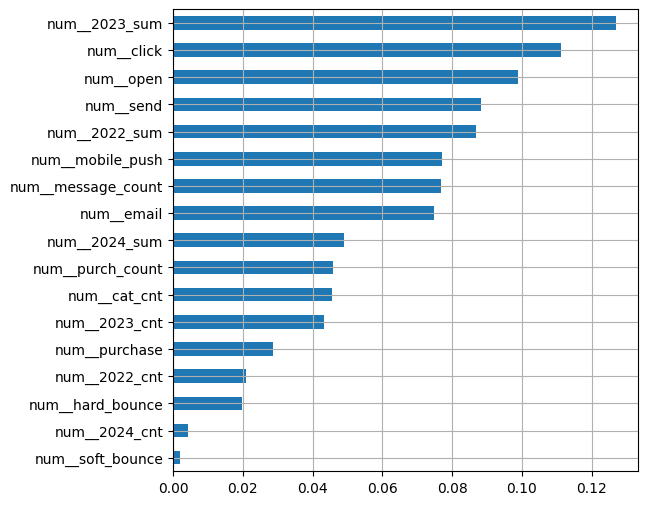

In [39]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#scores = cross_val_score(estimator=gs_q_dt, X=dt_X_train, y=y_train, 
#                         cv=skf, scoring='roc_auc', n_jobs=-1)
#print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

df_X_train = pd.DataFrame(dt_X_train)

plot_features_scores(model=gs_q_dt.best_estimator_, data=df_X_train, target=y_train, column_names=feature_names, model_type='rf')


In [40]:
import shap

model_lr = LogisticRegression(random_state=42)
model_lr.fit(dt_X_train, y_train)

c:\DEV\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [41]:
explainer = shap.LinearExplainer(model_lr, X_train)
shap_values = explainer(X_train)
shap_values.feature_names = feature_names.tolist()

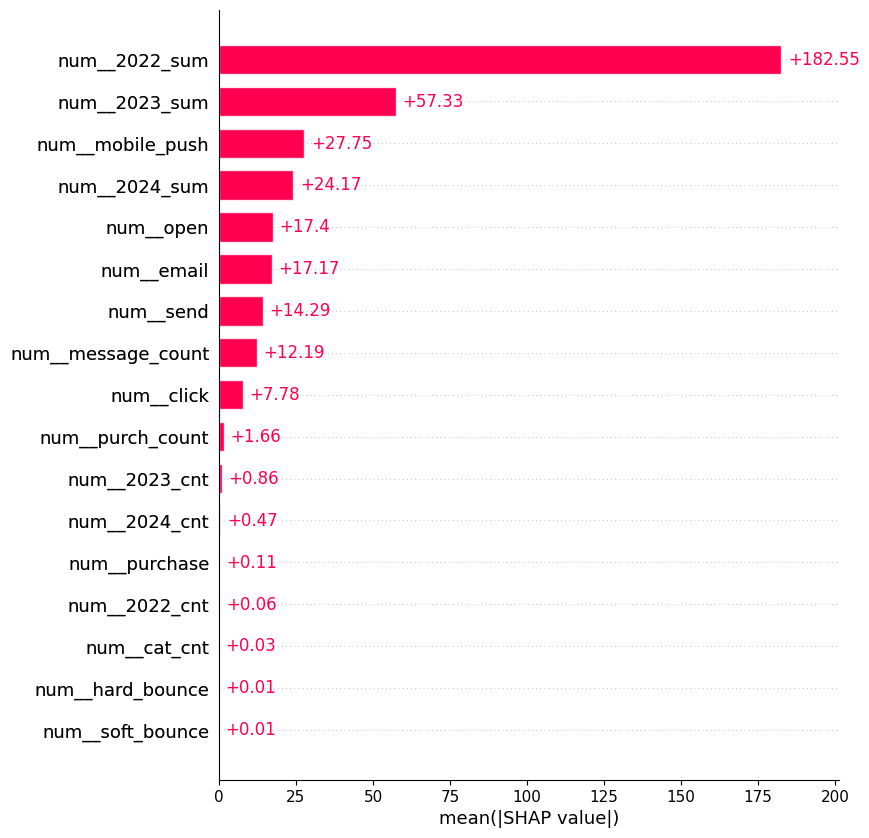

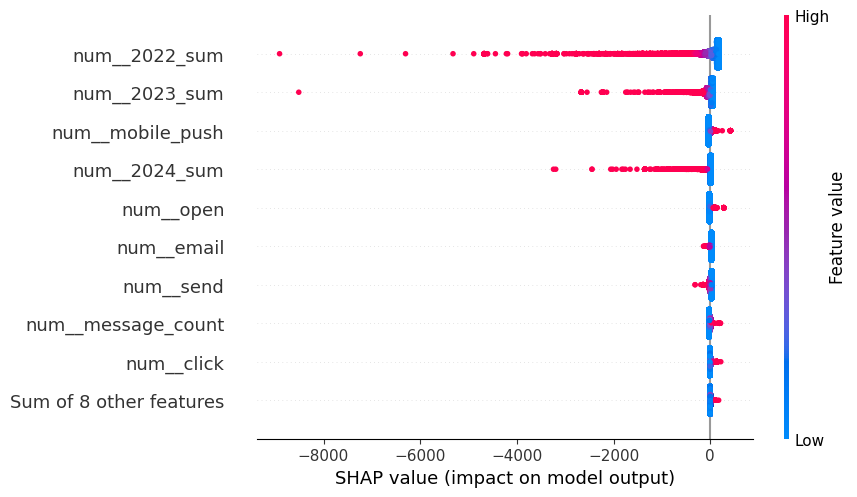

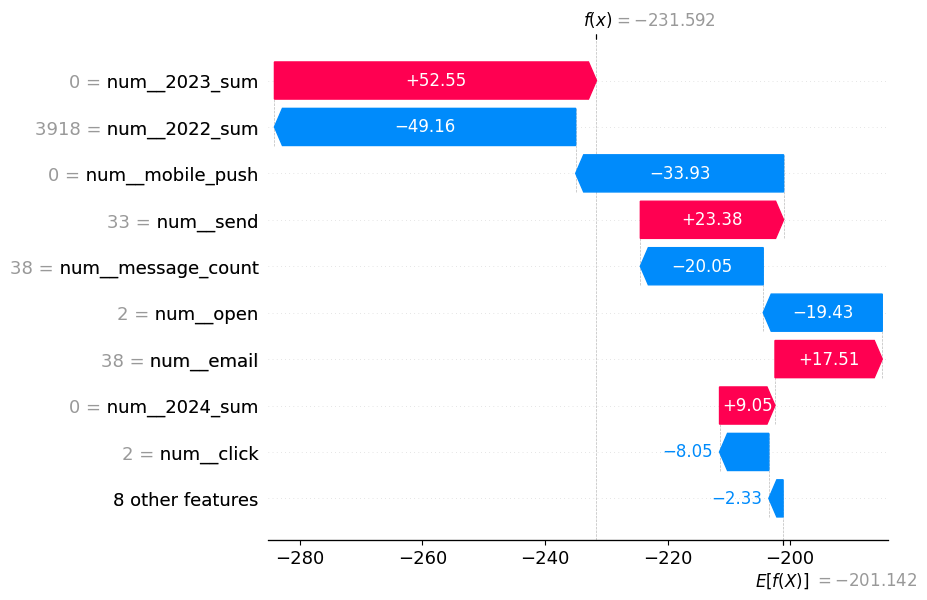

In [42]:
shap.plots.bar(shap_values, max_display=17) 
shap.plots.beeswarm(shap_values)
shap.plots.waterfall(shap_values[5]) 